# Hartree-Fock calculation of the CO molecule

In this notebook cell, we perform a **single-point Hartree-Fock (HF)** calculation on a **carbon monoxide (CO)** molecule using the `pyqint` library. The key steps are:

- The CO molecule is initialized using `MoleculeBuilder` by its chemical name.
- A **restricted Hartree-Fock (RHF)** calculation is run using the **STO-3G** basis set — a minimal basis set often used for quick, low-cost computations.
- The calculation does **not** include any geometry optimization; it simply evaluates the energy and electronic structure at the default geometry (a **single-point calculation**).
- Finally, the keys of the resulting dictionary from the HF computation are printed to show the available output data.

In [1]:
from pyqint import MoleculeBuilder, HF

# load molecule
mol = MoleculeBuilder().from_name('CO')
print(mol)

# perform (restricted) Hartree-Fock calculation using (small) STO-3g basis set
result = HF().rhf(mol, 'sto3g')

# Show keys of results dictionary
print(result.keys())

Cannot find module tqdm
Molecule: None
 O (0.000000,0.000000,0.967698)
 C (0.000000,0.000000,-1.290265)

dict_keys(['energy', 'nuclei', 'cgfs', 'energies', 'orbe', 'orbc', 'density', 'fock', 'transform', 'overlap', 'kinetic', 'nuclear', 'hcore', 'tetensor', 'time_stats', 'ecore', 'ekin', 'enuc', 'erep', 'ex', 'enucrep', 'nelec', 'mol', 'forces'])


## Matrix Plotting Utility Function

The `plot_matrix` function is a convenient helper for visualizing square matrices (e.g., density matrices, Fock matrices, etc.) using `matplotlib`. It takes a given matrix and displays it as a color-coded heatmap, along with annotated values and labeled axes.

#### Function Highlights:
- **Matrix visualization**: Uses `imshow` to display the matrix with a diverging colormap (`PiYG`) and a fixed color scale (`vmin=-1`, `vmax=1`) for consistent visual contrast.
- **Value annotations**: Each element of the matrix is displayed as a text label with two decimal places, centered in its respective cell.
- **Grid lines**: Dashed lines separate matrix cells for better readability.
- **Customizable labels**: X and Y axis tick labels are set using the provided `labels` list. Rotation of x-axis labels can be adjusted via the `xlabelrot` parameter.
- **Title support**: Optionally includes a title with an adjustable font size using the `titlefontsize` keyword argument.
- **Styling**: Tick labels and annotations are styled for clarity in compact plots (e.g., small fonts).

#### Parameters:
- `ax`: A `matplotlib.axes.Axes` object on which to plot the matrix.
- `mat`: A 2D NumPy array (square matrix) to be visualized.
- `labels`: List of labels for the matrix axes (e.g., basis function names).
- `title`: *(Optional)* Title of the plot.
- `xlabelrot`: *(Optional)* Rotation angle for x-axis labels (default is 0).
- `**kwargs`: Additional keyword arguments (e.g., `titlefontsize` for title styling).

This function is particularly useful for quickly inspecting quantum chemistry matrices during post-Hartree-Fock analysis or debugging.


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix(ax, mat, xlabels, ylabels, title = None, xlabelrot = 0, **kwargs):
    """
    Produce plot of matrix
    """
    ax.imshow(mat, vmin=-1, vmax=1, cmap='PiYG')
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(i, j, '%.2f' % mat[j,i], ha='center', va='center',
                    fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.hlines(np.arange(1, mat.shape[0])-0.5, -0.5, mat.shape[0] - 0.5,
              color='black', linestyle='--', linewidth=1)
    ax.vlines(np.arange(1, mat.shape[0])-0.5, -0.5, mat.shape[0] - 0.5,
              color='black', linestyle='--', linewidth=1)
    
    # add basis functions as axes labels
    ax.set_xticks(np.arange(0, mat.shape[0]))
    ax.set_xticklabels(xlabels, rotation=xlabelrot)
    ax.set_yticks(np.arange(0, mat.shape[0]))
    ax.set_yticklabels(ylabels, rotation=0)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    # add title if supplied
    if title:
        if 'titlefontsize' in kwargs:
            titlefontsize = kwargs['titlefontsize']
            ax.set_title(title, fontsize=titlefontsize)
        else:
            ax.set_title(title)

orblabels = []
for a in ['O', 'C']:
    for o in ['1s', '2s', '2px', '2py', '2pz']:
        orblabels.append('%s-%s' % (a,o))

## Overlap matrix

In Hartree-Fock theory, the **overlap matrix** $S$ plays a crucial role in describing how basis functions (typically atomic orbitals or contracted Gaussian functions) overlap in space. This matrix is central to solving the **Roothaan equations** for molecular orbitals in the **linear combination of atomic orbitals (LCAO)** approach.

The elements of the overlap matrix $S$ are defined as:

$$
S_{\mu\nu} = \int \phi_\mu(\mathbf{r}) \, \phi_\nu(\mathbf{r}) \, d\mathbf{r}
$$

Where:
- $\phi_\mu$ and $\phi_\nu$ are basis functions.
- The integral computes the spatial overlap between these two functions.

#### Properties:
- Because the basis functions are real, $S$ is a **real**, **symmetric**, and **positive-definite** matrix.
- The **diagonal elements** $S_{\mu\mu}$ represent the self-overlap of a basis function and are typically close to 1 for normalized functions.
- The **off-diagonal elements** $S_{\mu\nu}$ indicate the degree of spatial overlap between different basis functions:
  - Values close to 0 mean the functions are spatially well-separated or orthogonal.
  - Larger values indicate significant overlap.

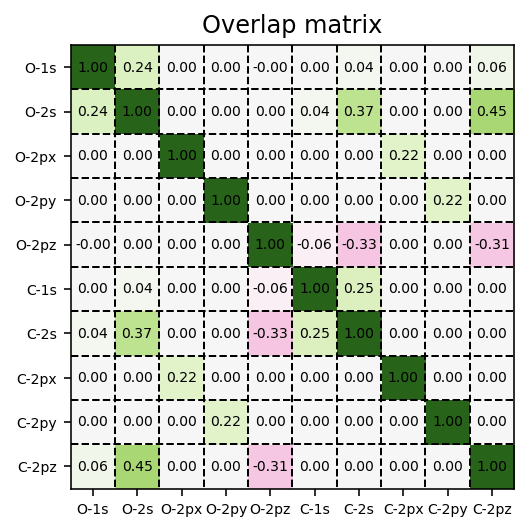

In [18]:
fig, ax = plt.subplots(1, 1, dpi=144, figsize=(4,4))
plot_matrix(ax, result['overlap'], xlabels=orblabels, ylabels=orblabels, title='Overlap matrix')

## Hamiltonian / Fock matrix

The **Fock matrix** $F$ is the central quantity in the Hartree-Fock method. It encodes both one-electron and two-electron interactions in the system and is used to determine the molecular orbitals through a self-consistent field (SCF) procedure.

#### Definition:
The elements of the Fock matrix are given by:

$$
F_{\mu\nu} = H_{\mu\nu} + G_{\mu\nu}
$$

Where:
- $H_{\mu\nu}$ is the **one-electron (core Hamiltonian) matrix**, consisting of:
  - Kinetic energy integrals
  - Nuclear attraction integrals
- $G_{\mu\nu}$ represents the **two-electron contribution**, including Coulomb and exchange terms.

Explicitly, the two-electron part is:

$$
G_{\mu\nu} = \sum_{\lambda\sigma} P_{\lambda\sigma} \left[ (\mu\nu|\lambda\sigma) - \frac{1}{2} (\mu\sigma|\lambda\nu) \right]
$$

Where:
- $P_{\lambda\sigma}$ is the **density matrix**.
- $(\mu\nu|\lambda\sigma)$ are the **electron repulsion integrals** (ERIs).
- The first term contributes to the **Coulomb interaction**, the second to **exchange**.

#### Properties:
- $F$ is a **real**, **symmetric** matrix.
- It is **density-dependent**, meaning it must be recomputed at each SCF iteration as the density matrix updates.
- Its eigenvalues and eigenvectors correspond to orbital energies and molecular orbitals, respectively.


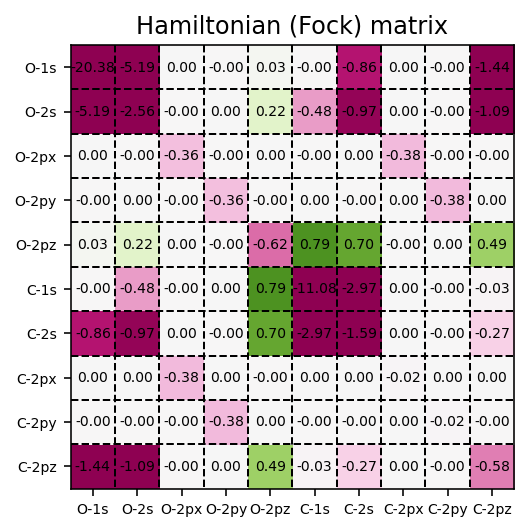

In [21]:
fig, ax = plt.subplots(1, 1, dpi=144, figsize=(4,4))
plot_matrix(ax, result['fock'], xlabels=orblabels, ylabels=orblabels, title='Hamiltonian (Fock) matrix')

## Coefficient matrix

The **coefficient matrix** $C$ contains the molecular orbital (MO) solutions obtained from the Hartree-Fock procedure. In a **restricted Hartree-Fock (RHF)** calculation, each molecular orbital is doubly occupied (paired electrons with opposite spins), and the same spatial orbitals are used for both spin-up and spin-down electrons.

#### Definition:
Each molecular orbital $\psi_i$ is expressed as a linear combination of atomic basis functions $\{ \phi_\mu \}$:

$$
\psi_i(\mathbf{r}) = \sum_{\mu} C_{\mu i} \, \phi_\mu(\mathbf{r})
$$

Here:
- $C_{\mu i}$ is the coefficient for basis function $\phi_\mu$ in molecular orbital $\psi_i$.
- The **$i$-th column** of the matrix $C$ contains all coefficients defining the $i$-th MO.

Thus, the coefficient matrix $C$ has the general structure:

$$
C = \begin{bmatrix}
C_{11} & C_{12} & \cdots & C_{1n} \\
C_{21} & C_{22} & \cdots & C_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
C_{n1} & C_{n2} & \cdots & C_{nn}
\end{bmatrix}
$$

Where:
- Each **row** corresponds to a basis function,
- Each **column** corresponds to a molecular orbital.

#### Number of Occupied Orbitals:
In an RHF calculation:
- The number of **occupied orbitals** is equal to **half the total number of electrons**, since each orbital holds **two electrons** with opposite spins.
- These occupied orbitals correspond to the **first few columns** of the coefficient matrix $C$.
- The remaining columns represent **virtual (unoccupied)** orbitals, which can participate in excitations or be used in post-HF methods like MP2 or CI.

#### Restricted vs. Unrestricted:
- In **restricted** Hartree-Fock (RHF), spatial orbitals are shared between spin-up and spin-down electrons. This is suitable for **closed-shell systems** where all electrons are paired.
- In contrast, **unrestricted** Hartree-Fock (UHF) allows different spatial orbitals for alpha and beta spins and is used for **open-shell systems** (e.g., radicals).

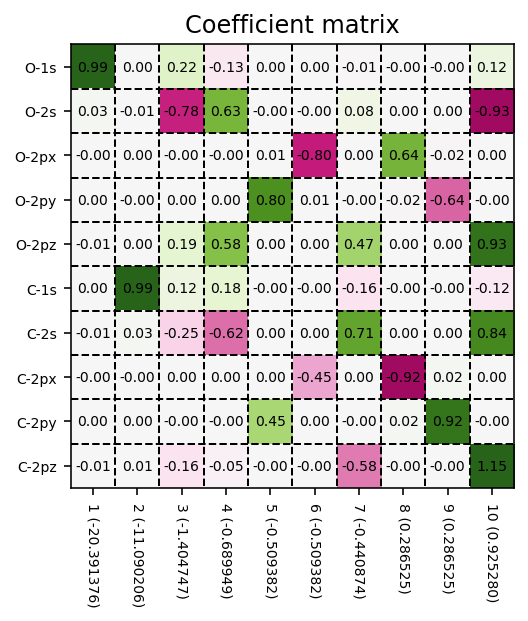

In [24]:
fig, ax = plt.subplots(1, 1, dpi=144, figsize=(4,4))
plot_matrix(ax, result['orbc'], ylabels=orblabels, xlabels=['%i (%f)' % (i+1, result['orbe'][i]) for i in range(len(result['orbc']))], title='Coefficient matrix', xlabelrot=-90)

## Visualizing Molecular Orbitals Using Contour Plots

In this section, we visualize the molecular orbitals (MOs) computed from the Hartree-Fock calculation using **contour plots**. These plots represent the **real-space wavefunctions** of the orbitals on a 2D grid.

#### What We're Plotting:
- The molecular orbitals are constructed from the basis functions and orbital coefficients (`cgfs` and `coeff`) returned by the calculation.
- For each orbital, we evaluate the wavefunction on a 2D grid in the $x$–$z$ plane (with $y = 0$) using the `plot_wavefunction` function.
- The resulting scalar field represents the amplitude of the wavefunction at each point in space.

#### Visualization Approach:
- We use `contourf` to create a **filled contour plot**, where color indicates the sign and magnitude of the wavefunction.
- We overlay `contour` lines to emphasize features like **nodal surfaces**, where the wavefunction crosses zero. These are important in understanding bonding and anti-bonding character.
- Each subplot corresponds to a different molecular orbital. The axes are labeled in **atomic units (a.u.)**.

This method provides an intuitive way to explore:
- The **shape** and **symmetry** of molecular orbitals,
- The **nodal structure** (regions of sign change),
- How electrons are distributed in space according to Hartree-Fock theory.

The visualization is particularly useful for interpreting chemical bonding and reactivity, as orbital shapes influence how molecules interact.


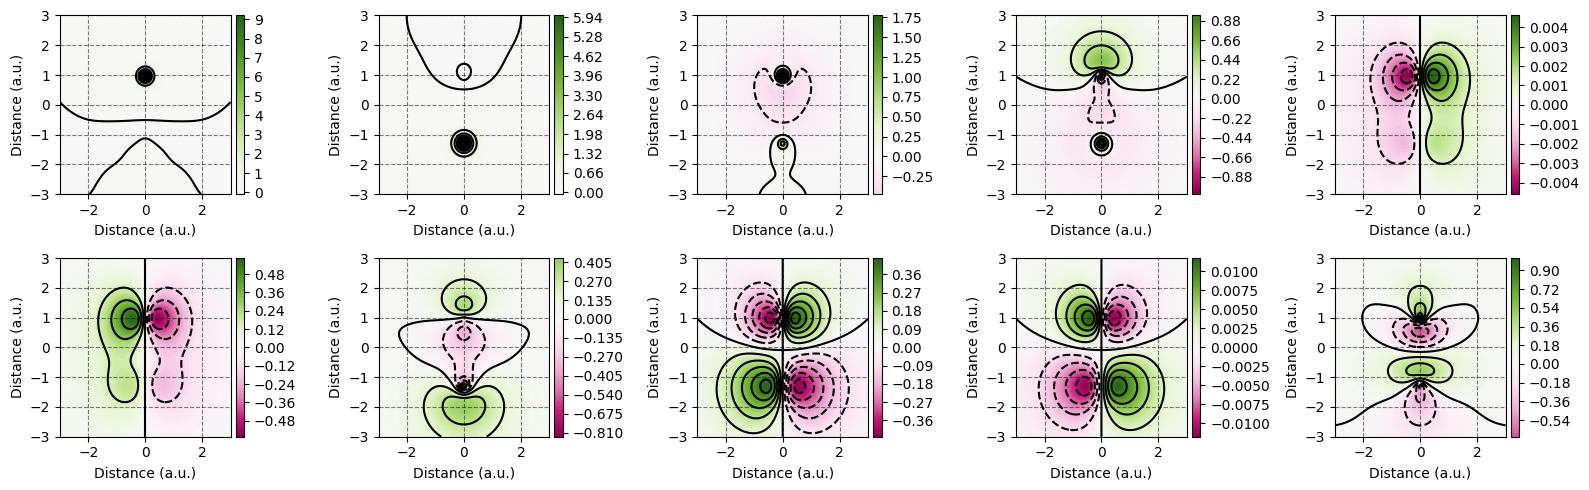

In [6]:
from pyqint import PyQInt
cgfs, coeff = result['cgfs'], result['orbc']
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_wavefunction(cgfs, coeff, x):
    # build integrator
    integrator = PyQInt()

    # build grid
    xx, zz = np.meshgrid(x,x)
    yy = np.zeros(len(x)**2)
    grid = np.vstack([xx.flatten(), yy, zz.flatten()]).reshape(3,-1).T
    res = integrator.plot_wavefunction(grid, coeff, cgfs).reshape((len(x), len(x)))

    return res

# visualize orbitals
fig, ax = plt.subplots(2,5, figsize=(16,5))
x = np.linspace(-3, 3, 150)
for i in range(0,2):
    for j in range(0,5):
        dens = plot_wavefunction(cgfs, coeff[:, i*5 + j], x)

        limit = max(abs(np.min(dens)), abs(np.max(dens)))

        # filled contours
        cf = ax[i, j].contourf(x, x, dens, levels=100, cmap='PiYG', vmin=-limit, vmax=limit)

        # add contour lines on top (zero-crossings, nodal planes)
        cs = ax[i, j].contour(x, x, dens, levels=10, colors='black')

        ax[i, j].set_xlabel('Distance (a.u.)')
        ax[i, j].set_ylabel('Distance (a.u.)')

        divider = make_axes_locatable(ax[i, j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        ax[i, j].grid(linestyle='--', alpha=0.5, color='black')
        fig.colorbar(cf, cax=cax, orientation='vertical')
plt.tight_layout()

## Generating Isosurfaces of Molecular Orbitals

To visualize the spatial structure of molecular orbitals, we generate **isosurfaces** from the wavefunction data. An isosurface represents a 3D surface where the wavefunction has a constant value — similar to a topographic contour line, but in three dimensions.

### What is an Isosurface?
An isosurface corresponds to all points in space where the wavefunction $\psi(\mathbf{r})$ equals a chosen value (called the **isovalue**):

$$
\psi(\mathbf{r}) = \pm \text{isovalue}
$$

These surfaces give insight into:
- The **shape** and **extent** of the orbital,
- **Nodal structure** (regions where the wavefunction changes sign),
- The **phase** of the orbital (positive or negative lobes).

#### Our Approach:
- We evaluate the wavefunction $\psi(\mathbf{r})$ on a 3D grid.
- We extract surfaces where the wavefunction equals **$\pm 0.03$** — this value is chosen to balance clarity and detail:
  - Smaller isovalues show more diffuse orbitals,
  - Larger isovalues highlight more localized features.
- Two separate meshes are generated:
  - One for the **positive** isosurface (typically shown in green),
  - One for the **negative** isosurface (typically shown in purple or pink).
- The meshes are rendered with **transparency** and **wireframe overlays** to improve visibility and spatial understanding.


In [7]:
from pytessel import PyTessel
import numpy as np
import trimesh
import pythreejs as p3
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from math import factorial
from scipy.special import assoc_laguerre
from scipy.special import lpmv
from scipy.special import sph_harm

integrator = PyQInt()

def generate_scalarfield(N, sz, res):
    x = np.linspace(-sz, sz, res)
    xx, yy, zz = np.meshgrid(x,x,x)
    grid = np.vstack([xx.flatten(), yy.flatten(), zz.flatten()]).reshape(3,-1).T

    field = integrator.plot_wavefunction(grid, result['orbc'][:,N], result['cgfs']).reshape(res, res, res)
    return field

def generate_isosurfaces(N, sz, res, name):
    pytessel = PyTessel()
    field = generate_scalarfield(N, sz, res)
    unitcell = np.diag(np.ones(3) * 3 * 2)
    pytessel = PyTessel()
    isovalue = 0.03
    vertices, normals, indices = pytessel.marching_cubes(field.flatten(), field.shape, unitcell.flatten(), isovalue)
    pytessel.write_ply('%s_pos.ply' % name, vertices, normals, indices)
    vertices, normals, indices = pytessel.marching_cubes(field.flatten(), field.shape, unitcell.flatten(), -isovalue)
    pytessel.write_ply('%s_neg.ply' % name, vertices, normals, indices)

def visualize_mesh(name):
    mesh_pos = trimesh.load_mesh("%s_pos.ply" % name)
    mesh_neg = trimesh.load_mesh("%s_neg.ply" % name)

    geometry_pos = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_pos.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_pos.faces.astype(np.uint32).ravel(), normalized=False)
        }
    )
    
    geometry_neg = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_neg.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_neg.faces.astype(np.uint32).ravel(), normalized=False),
        }
    )

    solid_material_pos = p3.MeshStandardMaterial(
        color="#276419",
        side="DoubleSide",
        transparent=True,
        opacity=0.3
    )
    solid_material_neg = p3.MeshStandardMaterial(
        color="#8e0152",
        side="DoubleSide",
        transparent=True,
        opacity=0.3
    )

    mesh_object_pos = p3.Mesh(geometry=geometry_pos, material=solid_material_pos)
    mesh_object_neg = p3.Mesh(geometry=geometry_neg, material=solid_material_neg)
    mesh_object_pos.rotateY(-np.pi/2)
    mesh_object_neg.rotateY(-np.pi/2)

    # Wireframe Overlay
    wireframe_material = p3.LineBasicMaterial(color="black", linewidth=1.0)  # Thin black lines
    wireframe_pos = p3.LineSegments(
        p3.EdgesGeometry(geometry_pos),  # Extracts edges from geometry
        wireframe_material,
        transparent=True,
        opacity=0.3
    )
    wireframe_neg = p3.LineSegments(
        p3.EdgesGeometry(geometry_neg),  # Extracts edges from geometry
        wireframe_material,
        transparent=True,
        opacity=0.3
    )
    wireframe_pos.rotateY(-np.pi/2)
    wireframe_neg.rotateY(-np.pi/2)

    # Atom spheres: Carbon (black) at z = -1, Oxygen (red) at z = +1
    carbon_sphere = p3.Mesh(
        geometry=p3.SphereGeometry(radius=0.2, widthSegments=32, heightSegments=32),
        material=p3.MeshStandardMaterial(color="black")
    )
    carbon_sphere.position = [0, 0, -1.290265/1.8897259886]

    oxygen_sphere = p3.Mesh(
        geometry=p3.SphereGeometry(radius=0.25, widthSegments=32, heightSegments=32),
        material=p3.MeshStandardMaterial(color="red")
    )
    oxygen_sphere.position = [0, 0, 0.967698/1.8897259886]
    
    # Lighting setup
    ambient_light = p3.AmbientLight(color="white", intensity=4)
    
    # Create Scene
    scene = p3.Scene(children=[mesh_object_pos, 
                               mesh_object_neg, 
                               wireframe_pos, 
                               wireframe_neg, 
                               ambient_light,
                               carbon_sphere, 
                               oxygen_sphere,
                               p3.AxesHelper(size=5)
                              ])
    camera = p3.PerspectiveCamera(position=[5, 5, 5], fov=50)
    controller = p3.OrbitControls(controlling=camera)

    renderer = p3.Renderer(
        scene=scene, camera=camera, controls=[controller], 
        width=512, height=512, antialias=True
    )
    
    return renderer

def parse_orbital(orb):
    match = re.findall(r"-?\d+", orb)  # Extract all numbers
    return tuple(map(int, match))  # Convert to integers and return as tuple

def update_plot(N):
    name = 'MO_%03i' % N
    generate_isosurfaces(N-1, 5, 70, name)
    renderer = visualize_mesh(name)
    display(renderer)
    
# Create an interactive slider to vary the number of basis functions
N_slider = widgets.IntSlider(
    min=1, max=10, step=1, value=0,
    description="Solution index"
)

# Link slider to update function and display interactive UI
widgets.interactive(update_plot, N=N_slider)

interactive(children=(IntSlider(value=1, description='Solution index', max=10, min=1), Output()), _dom_classes…